In [1]:
%matplotlib inline
import sys 
sys.path.append('../../../../')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow, gpitch
reload(gpitch)
from gpitch.amtgp import logistic
from scipy.fftpack import fft, ifft, ifftshift
from scipy import signal
import time
from gpitch import myplots
import soundfile
import peakutils
import sounddevice
import pickle

plt.rcParams['figure.figsize'] = (16, 5)  # set plot size

In [2]:
filename = '../../../../../datasets/maps/test_data/segment4-down.wav'
N = 32000
y, fs = soundfile.read(filename, frames=N)
y -= y.mean() 
x = np.linspace(0, (N-1.)/fs, N)

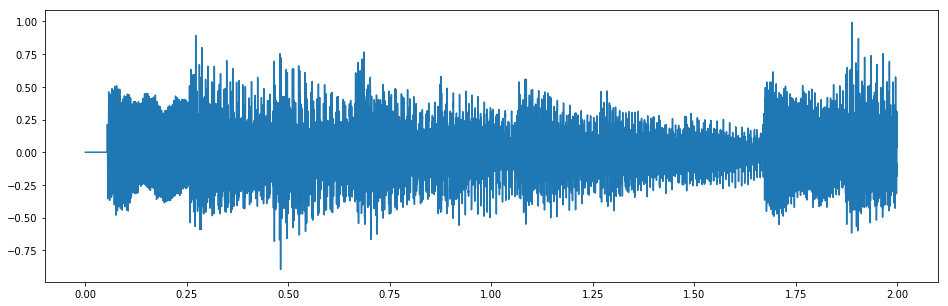

In [3]:
plt.figure()
plt.plot(x, y)

In [4]:
Y = fft(y)
S = 2./N * np.abs(Y[:N/2])
F = np.linspace(0, 0.5*fs, N/2)
S /= S.sum() 

(0, 4000)

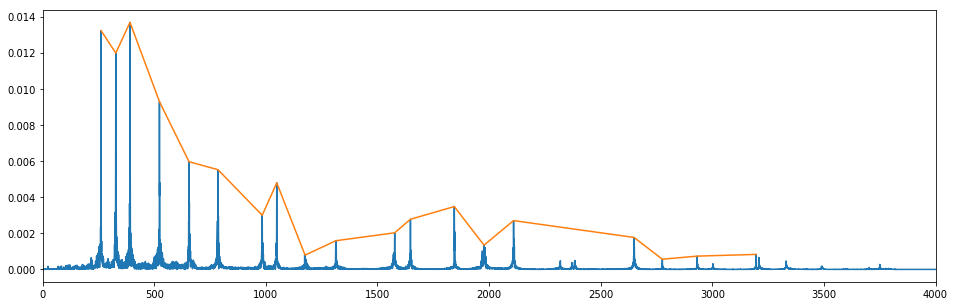

In [5]:
idx = peakutils.indexes(S, thres=0.0005/max(S), min_dist=100)
F_star, S_star = F[idx], S[idx]
var_scale = S_star.sum()
S_star /= 4.*var_scale 
#do not forget to normalize the variances please !!!!!!!!!
Nc = F_star.size

plt.figure()
plt.plot(F, S)
plt.plot(F[idx], S[idx])
plt.xlim([0, 4000])

(0, 4000)

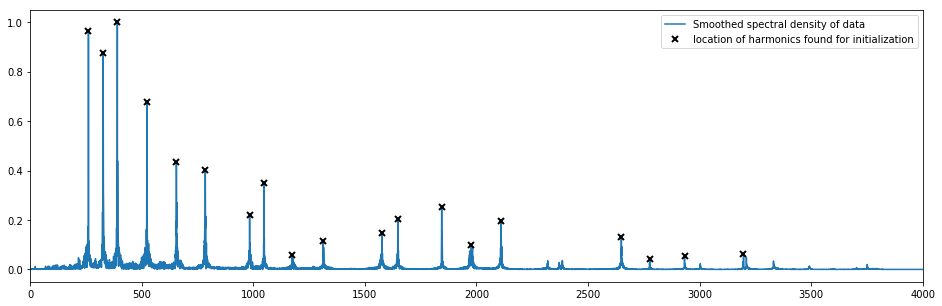

In [6]:
plt.figure()
plt.plot(F, S/np.max(S))
plt.plot(F_star, S_star/np.max(S_star), 'xk', mew=2)
plt.legend(['Smoothed spectral density of data', 'location of harmonics found for initialization'])
plt.xlim([0, 4000])

In [7]:
kern_com = gpitch.kernels.MaternSpecMix(input_dim=1, lengthscales=0.1, variances=S_star, 
                                        frequencies=F_star, Nc=Nc)
kern_act = gpflow.kernels.Matern32(input_dim=1, lengthscales=0.1, variance=10.)

In [8]:
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
minibatch_size = 200
dec = 160  # samples per window, decimation factor
z = np.vstack((x[::dec].copy(), x[-1].copy()))
m = gpitch.modgp.ModGP(x=x, y=y, z=z, kern_com=kern_com, kern_act=kern_act, whiten=True,
                       minibatch_size=minibatch_size)

In [9]:
m.kern_com.fixed = True
m.kern_com.lengthscales.fixed = False
m.kern_com.lengthscales.transform = gpflow.transforms.Logistic(0., 10.0)
m.fixed_msmkern_params(freq=False, var=True)
m.kern_act.fixed = False
m.likelihood.variance.fixed = False
m.z.fixed = True

In [10]:
m

Name,values,prior,constraint
model.kern_act.lengthscales,[ 0.1],None,+ve
model.kern_act.variance,[ 10.],None,+ve
model.kern_com.frequency_1,[ 261.51634477],None,+ve
model.kern_com.frequency_10,[ 1313.08206763],None,+ve
model.kern_com.frequency_11,[ 1577.09856866],None,+ve
model.kern_com.frequency_12,[ 1647.60297519],None,+ve
model.kern_com.frequency_13,[ 1844.1152572],None,+ve
model.kern_com.frequency_14,[ 1977.12357022],None,+ve
model.kern_com.frequency_15,[ 2109.63185199],None,+ve
model.kern_com.frequency_16,[ 2649.16557285],None,+ve


In [ ]:
st = time.time()
logt = []
logx = []
logf = []
def logger(x):
    if (logger.i % 10) == 0:
        logx.append(x)
        logf.append(m._objective(x)[0])
        logt.append(time.time() - st)
    logger.i+=1
logger.i = 1
m.x.minibatch_size = minibatch_size
m.y.minibatch_size = minibatch_size

In [ ]:
maxiter = 5000
m.optimize(method=tf.train.AdamOptimizer(learning_rate=0.01), maxiter=maxiter, 
           callback=logger)

In [ ]:
plt.plot(-np.array(logf))
plt.xlabel('iteration')
plt.ylabel('ELBO')

In [ ]:
mean_f, var_f, mean_g, var_g, x_plot  = m.predict_all(x)
xlim = [0.0, 2.0]
myplots.plot_results(mean_f, var_f, mean_g, var_g, x_plot, y, z, xlim)

In [ ]:
prediction = logistic(mean_g)*mean_f
plt.figure()
plt.plot(x, prediction)

In [ ]:
m

In [ ]:
k_plot_model = m.kern_com.compute_K(x, np.asarray(0.).reshape(-1,1))
plt.figure(figsize=(16, 4))
plt.plot(x, k_plot_model, lw=2)

In [ ]:
N = x.size
Yk1 = fft(k_plot_model.reshape(-1,)) #  FFT data
Sk1 =  2./N * np.abs(Yk1[0:N//2]) #  spectral density data

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(F, S / np.max(np.abs(S)), lw=2)
plt.legend([' Spectral density data'])
plt.xlabel('Frequency (Hz)')
plt.xlim([0, 8000])

plt.subplot(2, 1, 2)
plt.plot(F, S / np.max(np.abs(S)), 'r', lw=2)
plt.plot(F, Sk1 / np.max(np.abs(Sk1)), lw=2)
plt.legend([' Spectral density learned component kernel'])
plt.xlabel('Frequency (Hz)')
plt.xlim([0, 4000])

In [ ]:
m.logf = logf
pickle.dump(m, open("save_model_background.p", "wb"))